# Librería para procesamiento de datos PyEO

Adaptación realizada por:

- David Alonso Rueda Rodríguez - Ing. Catasral y Geodesta
- Luís Manuel Guerrero Buelvas - Ing. Ambiental

## Práctica 01. Prueba Inicialización de datos

En este caso se verificarán las rutas de instalación de los servicios requeridos:

### 0. Requerimientos para ejecución de la librería

Este paquete de datos requiere la previa instalación de los siguientes elementos:

- Anaconda
- Descarga y descompresión del paquete Sen2Core (http://step.esa.int/main/third-party-plugins-2/sen2cor/)
- Descarga del repositorio de datos git del proyecto PyEO (https://github.com/clcr/pyeo)
- Libreŕia Folium (https://python-visualization.github.io/folium/installing.html)

### 1. Importando las librerías

In [1]:
import sys                                                                        # Importar librería del sistema
sys.path.append("/home/davo/Documentos/pyeo")                                     # Agregar la ruta en donde está alojada la pyeo
sen2cor_path = r"/home/davo/Documentos/Sen2Cor-02.08.00-Linux64/bin/L2A_Process"  # Agregar la ruta del programa Sen2Core, programa original de la ESA
import pyeo.core as pyeo                                                          # Importar la librería PyEO para análisis de Imágenes Sentinel.
import matplotlib.pyplot as plt                                                   # Importar librería matplotlib para presentación de gráficos
import gdal                                                                       # Importar librería gdal para trabajo con datos espaciales
import pprint                                                                     # Importar librería para impresión de datos al sistema
import os                                                                         # Importar librería os para manejo de archivos

Tenacity, Planet and Multiprocessing are required for Planet data downloading


### 2. Creación de archivo log

El objetivo de esta actividad es actividad el archvio para seguimiento de las actividades realizadas

In [2]:
# Creación de archivo para seguimiento de actividades
pyeo.init_log("logs/training_log.log")

2019-05-16 09:38:02,902: INFO: ****PROCESSING START****


<Logger pyeo.core (DEBUG)>

### 3. Comprobación de las funciones

Esta prueba llama a la función **is_tif** que hace parte de la librería pyeo, la función únicamente comprueba que el archivo tenga la extensión .tif, en caso positivo retorna el valor **True** en caso contrario **False**.

In [3]:
# Esta prueba permite identificar si el llamado a las funciones está trabajando correctamento
pyeo.is_tif("prueba.tif")

True

In [4]:
def show_satellite_image(image_path):
    img = gdal.Open(image_path)
    array = img.GetVirtualMemArray()
    img_view = array.transpose([1,2,0])
    plt.imshow(img_view)
    array = None
    img = None

In [224]:
def mapa_area_interes(json_path, name_area, zoom_op = 10, tipo_image = 'Stamen Terrain'):
    """
    Función mapa_area_interes
    
    Objetivo: 
    
    - Generar mapa de interés leyendo un archivo geojson. Como resultado se presenta
    un mapa del área de interés, y agregar una marca de posición con el nombre del
    área
    
    Variables de Entrada:
    
    - json_path  = Dirección donde está almacenado el archivo json
    - name_area  = Nombre asignado al área de trabajo
    - zoom_op    = Zoom para presentación del área por defecto 10
    - tipo_image = Tipo de imagen para mostrar, por defecto se establece Stamen Terrain
        se tienen otras opciones que son heredadas desde follium:
            * OpenStreetMap
            * Stament Terrain
            * Mapbox Bright
            * CartoDB positron
    
    Desarrollado por: David Alonso Rueda Rodríguez    
    
    Versiones:
    
    000 - 20190516. Se agrega función para estimar centroide, y documentación de ayuda.
    1   - 20190515. Preparación inicial de la función.
    
    """
    import geojson_utils
    import folium as fl
    import geojson
    import json
    import os
    
    area_interes = os.path.join('',json_path)    

    with open(area_interes) as g:
        gj = geojson.load(g)
    entidades = gj['features'][0]
    centroide = centroid(entidades['geometry'])
    cent = [centroide['coordinates'][1], centroide['coordinates'][0]]
    
    m= fl.Map( 
        location= cent,
        tiles=tipo_image,
        zoom_start = zoom_op,
    )
    fl.GeoJson(
        area_interes,
        name=name_area
    ).add_to(m)
    fl.Marker(
        location= cent,
        popup = name_area
    ).add_to(m)
    fl.LayerControl().add_to(m)
    print("\n\nMapa del {}" .format(name_area))
    return m

### 4. Obtener datos de acceso a programa Copernicus

Se leerán los datos de usuario almacenados en un archivo **.ini**, para confirmar que todo ha funcionado se imprimirá el nombre del usuario en el archivo

In [6]:
import configparser                                            # Importar módulo para acceso a archivo de configuración
conf = configparser.ConfigParser()                             # Crear un objeto ConfigParser y asignarlo a la variables conf
archivo_configuracion = "../lic/kinangop.ini"                  # Nombre y ruta del archivo con las variables de acceso al servicio Copernicus
conf.read(archivo_configuracion)                               # Leer el archivo con las variables de acceso al servicio Copernicus
print('Nombre de usuario: {}' .format(conf['sent_2']['user']))  # Mostrar los datos de la configuración

Nmbre de usuario: polybispo


### 5. Selección y descarga de datos
#### 5.1 Identificación del área

El área de trabajo para consulta se localiza en Colombia, en el Departamento del Tolima en el municipio de Cajamarca. En el área se presenta una zona con pinos destinados al aprovechamiento forestal. La siguiente ventana presenta el área de interés:




In [225]:
# Datos de entrada para presentación de mapa de interés
archivo_aoi = 'src/AOI.json'
nombre_mapa = "Área de Interés"

mapa_area_interes (json_path=archivo_aoi, name_area=nombre_mapa, zoom_op=12)



Mapa del Área de Interés


#### 5.2 Identificación de datos disponible

Esta función presenta las imágenes disponibles en la zona que cumplen las siguientes condiciones:

- Cobertura de nubes menor a 15%
- Fecha de inicio de datos Junio de 2018
- Fecha final de toma de datos Mayo de 2019
- Datos de acceso (variable -conf-)

In [93]:
# Consulta número de imágenes disponibles con las siguientes condiciones:

fecha_inicio = "20180601"                             # Fecha de inicio de datos
fecha_final = "20190501"                              # Fecha fin de datos
cobertura_nubes = 15                                  # Cobertura de nubes menor de este número

# Llamado a función que retorna la imágenes disponibles con las condiciones previamente identificadas

imagenes_disponibles = pyeo.check_for_s2_data_by_date (archivo_aoi, fecha_inicio, fecha_final, conf, cobertura_nubes)

2019-05-16 11:06:10,962: INFO: Querying for imagery between 20180601 and 20190501 for aoi src/AOI.json
2019-05-16 11:06:10,968: INFO: Sending query:
footprint: POLYGON((-75.5760 4.5170,-75.5760 4.4120,-75.4370 4.4120,-75.4370 4.5170,-75.5760 4.5170))
start_date: 2018-06-01T00:00:00Z
end_date: 2019-05-01T00:00:00Z
 cloud_cover: 15 
2019-05-16 11:06:12,758: INFO: Search returned 1 images


In [94]:
imagenes_disponibles

OrderedDict([('48194f04-dec1-44db-bee7-05d1a2ad09d9',
              {'title': 'S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450',
               'link': "https://scihub.copernicus.eu/apihub/odata/v1/Products('48194f04-dec1-44db-bee7-05d1a2ad09d9')/$value",
               'link_alternative': "https://scihub.copernicus.eu/apihub/odata/v1/Products('48194f04-dec1-44db-bee7-05d1a2ad09d9')/",
               'link_icon': "https://scihub.copernicus.eu/apihub/odata/v1/Products('48194f04-dec1-44db-bee7-05d1a2ad09d9')/Products('Quicklook')/$value",
               'summary': 'Date: 2019-02-13T15:26:41.025Z, Instrument: MSI, Mode: , Satellite: Sentinel-2, Size: 792.78 MB',
               'datatakesensingstart': datetime.datetime(2019, 2, 13, 15, 26, 41, 25000),
               'beginposition': datetime.datetime(2019, 2, 13, 15, 26, 41, 25000),
               'endposition': datetime.datetime(2019, 2, 13, 15, 26, 41, 25000),
               'ingestiondate': datetime.datetime(2019, 2, 13, 22

### 6. Descarga de imágenes

Este procedimiento requiere aclarar la fuente de datos, datos de acceso a la plataforma de descarga y el conjunto de imágenes a descargar.

La duración total de la actividad dependerá de la conexión utilizada, y el número de imágenes a descargarse.

En caso que el directorio *images* no exista, se generará un error

In [227]:
# Diligenciar las siguientes variables para iniciar la descarga del conjunto de imágenes disponible

fuente_datos = "scihub"                               # Datos disponibles en: scihub, aws y google_cloud
usuario = conf["sent_2"]["user"]
contrasenia = conf["sent_2"]["pass"]
dir_salida = "images"

dir_img = os.getcwd() + "/" + dir_salida
if os.path.exists(dir_img):
    pass
else:
    os.mkdir(dir_img)


pyeo.download_s2_data(imagenes_disponibles, dir_salida, source = fuente_datos, user = usuario, passwd = contrasenia)

2019-05-16 15:45:08,021: INFO: {} is not a valid L1 file
2019-05-16 15:45:08,032: INFO: Downloading S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450 from scihub
2019-05-16 15:45:08,040: INFO: Downloading 48194f04-dec1-44db-bee7-05d1a2ad09d9 from scihub
Downloading: 100%|██████████| 831M/831M [1:23:51<00:00, 188kB/s] 
MD5 checksumming: 100%|██████████| 831M/831M [00:09<00:00, 87.7MB/s] 
2019-05-16 17:09:11,126: INFO: Unzipping images/S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450.zip to images
2019-05-16 17:10:03,486: INFO: Removing images/S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450.zip


#### 7. Visualización de la imagen descargada

Para esta actividad inicialmente se utilziará matplotlib

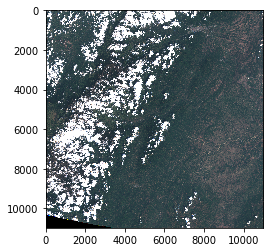

In [228]:
%matplotlib inline
ruta_imagen = "images/S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450.SAFE/GRANULE/L1C_T18NVK_A019041_20190213T152636/IMG_DATA/"

foo = (ruta_imagen + "T18NVK_20190213T152641_TCI.jp2")
show_satellite_image(foo)

### 6. Preprocesamiento de imágenes

Las imágenes descargadas/producidas por el proyecto Copernicus carecen de correcciones a los efectos causados por la atmósfera, por esa razón la ESA ha creado el módulo sen2cor para corregir los productos ópticos del proyecto.

#### 6.1 Archivos descargados

La ruta de pre-procesamiento a utilizar corresponde a la ubición en la cual se han guarado las imágenes descargadas, para la presenta actividad corresponde a:

**../PyEO_Tutoriales/Practica001_TodoEnOrden/images/**

Las nuevas imágenes se crearán en la siguiente ruta:

**../PyEO_Tutoriales/Practica001_TodoEnOrden/**

In [235]:
import os
ruta_imagen = os.getcwd()+'/'+'images/'
file_list = os.listdir(ruta_imagen)
for file in file_list:
    path = os.path.join("images", file)
    pyeo.apply_sen2cor(path, sen2cor_path)

2019-05-16 18:07:46,496: INFO: calling subprocess: ['/home/davo/Documentos/Sen2Cor-02.08.00-Linux64/bin/L2A_Process', 'images/S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450.SAFE']
2019-05-16 18:07:52,308: INFO: Sentinel-2 Level 2A Processor (Sen2Cor). Version: 2.8.0, created: 2019.02.20, supporting Level-1C product version 14.2 - 14.5 started ...

2019-05-16 18:07:52,315: INFO: Product version: 14.5

2019-05-16 18:07:52,318: INFO: Operation mode: TOOLBOX

2019-05-16 18:07:52,326: INFO: Processing baseline: 99.99

2019-05-16 18:07:52,330: INFO: Progress[%]:  0.00 : Generating datastrip metadata

2019-05-16 18:07:59,666: INFO: L1C datastrip found, L2A datastrip successfully generated

2019-05-16 18:08:00,325: INFO: No resolution specified, will process 20 and 10 m resolution

2019-05-16 18:08:00,331: INFO: 20 m resolution will be downsampled to 60 m

2019-05-16 18:08:03,498: INFO: Progress[%]: 0.12 : PID-30010, L2A_ProcessTile: processing with resolution 20 m, elapsed time[

2019-05-16 18:19:18,440: INFO: MemoryError

2019-05-16 18:19:18,442: INFO: Progress[%]: 100.00 : Application terminated with at least one error.

2019-05-16 18:19:18,443: INFO: 

2019-05-16 18:19:23,005: INFO: sen2cor processing finished for images/S2A_MSIL1C_20190213T152641_N0207_R025_T18NVK_20190213T201450.SAFE
2019-05-16 18:19:23,083: INFO: Validating:
2019-05-16 18:19:23,085: INFO: Checking images/S2A_MSIL2A_20190213T152641_N0207_R025_T18NVK_20190213T201450.SAFE for incomplete 10m imagery
2019-05-16 18:19:23,254: ERROR: 10m imagery not present in images/S2A_MSIL2A_20190213T152641_N0207_R025_T18NVK_20190213T201450.SAFE


BadS2Exception: 

In [249]:
import gdal
ruta_imagen = os.getcwd()+'/'+'S2A_MSIL2A_20190213T152641_N9999_R025_T18NVK_20190516T230751.SAFE'
image = gdal.Open(ruta_imagen)

/home/davo/Documentos/PyEO_Tutoriales/Practica001_TodoEnOrden/S2A_MSIL2A_20190213T152641_N9999_R025_T18NVK_20190516T230751.SAFE
